In [36]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

In [37]:
df = pd.read_csv(r"C:\Users\thefl\Documents\Code\SM-Mentoring\SM-Demand Forecasting\Data\raw\complete_dataset.csv")

In [38]:
df=df.sort_values(by='date')
df.ffill(inplace=True)

In [39]:
df['date']=pd.to_datetime(df['date'])

In [40]:
df['day_of_week']=df['date'].dt.day_name()

In [44]:
df[['day_of_week','holiday','date']]

,day_of_week,holiday,date
0,Thursday,Y,2015-01-01
1,Friday,N,2015-01-02
2,Saturday,N,2015-01-03
3,Sunday,N,2015-01-04
4,Monday,N,2015-01-05
...,...,...,...
2101,Friday,N,2020-10-02
2102,Saturday,N,2020-10-03
2103,Sunday,N,2020-10-04
2104,Monday,N,2020-10-05


<Axes: xlabel='school_day'>

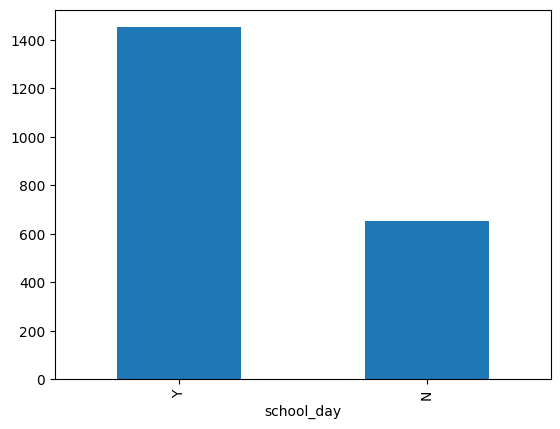

In [43]:
df['school_day'].value_counts().plot(kind='bar')

In [41]:
df

,date,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday,day_of_week
0,2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,N,Y,Thursday
1,2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,N,N,Friday
2,2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,N,N,Saturday
3,2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,N,N,Sunday
4,2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,N,N,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2101,2020-10-02,99585.835,-6.076028,41988.240,26.980251,57597.595,-30.173823,0.625000,12.8,26.0,22.0,0.0,N,N,Friday
2102,2020-10-03,92277.025,-1.983471,44133.510,32.438156,48143.515,-33.538025,0.583333,17.4,29.4,19.8,0.0,N,N,Saturday
2103,2020-10-04,94081.565,25.008614,88580.995,26.571687,5500.570,-0.163066,0.062500,13.5,29.5,8.4,0.0,N,N,Sunday
2104,2020-10-05,113610.030,36.764701,106587.375,39.616015,7022.655,-6.511550,0.083333,9.1,12.7,7.3,12.8,N,N,Monday


In [24]:
ohe_Encoder=OneHotEncoder(drop='first',sparse_output=False).set_output(transform='pandas')
categorical_col=['school_day','holiday']
encoded_df=ohe_Encoder.fit_transform(df[categorical_col])
df=pd.concat([df,encoded_df],axis=1).drop(columns=categorical_col)

In [32]:
# df

In [26]:
# Rename columns for Prophet
df = df.rename(columns={"date": "ds", "demand": "y"})
df = df[["ds", "y", "min_temperature", "max_temperature", "solar_exposure", "RRP", "school_day_Y"]]

In [27]:
model = Prophet()
model.add_country_holidays(country_name='AU')
model.add_regressor('min_temperature')
model.add_regressor('max_temperature')
model.add_regressor('solar_exposure')
model.add_regressor('RRP')
model.add_regressor('school_day_Y')

In [28]:
model.fit(df)

18:32:10 - cmdstanpy - INFO - Chain [1] start processing
18:32:10 - cmdstanpy - INFO - Chain [1] done processing


In [29]:
future=model.make_future_dataframe(periods=30)
future["min_temperature"] = df["min_temperature"].iloc[-1]
future["max_temperature"] = df["max_temperature"].iloc[-1]
future["solar_exposure"] = df["solar_exposure"].iloc[-1]
future["RRP"] = df["RRP"].iloc[-1]
future["school_day_Y"] = df["school_day_Y"].iloc[-1]

In [30]:
forecast=model.predict(future)

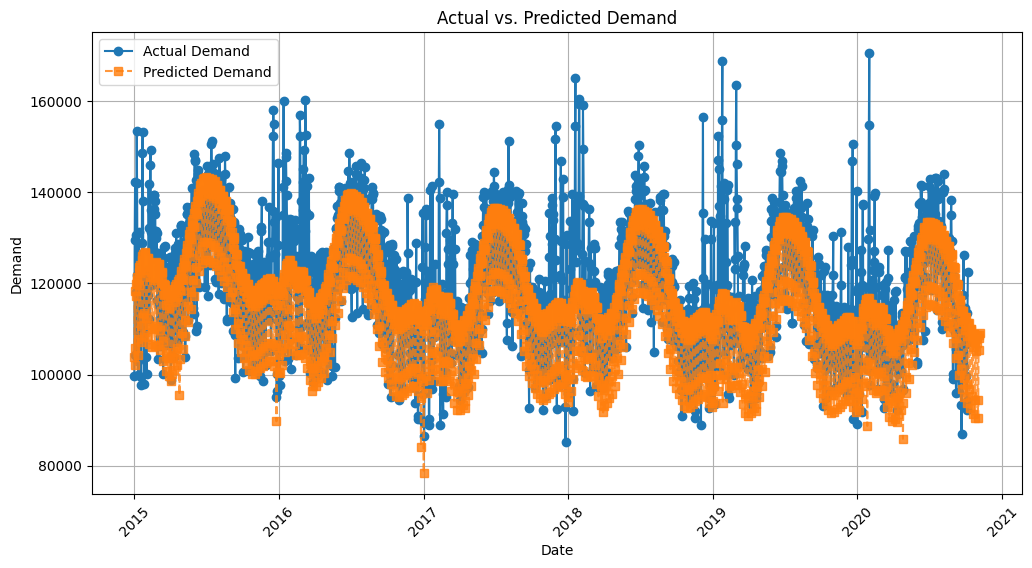

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(df["ds"], df["y"], label="Actual Demand", marker='o', linestyle="-")
plt.plot(forecast["ds"], forecast["yhat"], label="Predicted Demand", marker='s', linestyle="--", alpha=0.8)
plt.xlabel("Date")
plt.ylabel("Demand")
plt.title("Actual vs. Predicted Demand")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()